# <a href="#VanillaGAN setup"> VanillaGAN setup and training</a><br>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from methods import gan, accuracy_XGboost, aae  # , vae
from helperfunctions import *

import xgboost as xgb
import time
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ETL

In [4]:
file_name = 'data/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


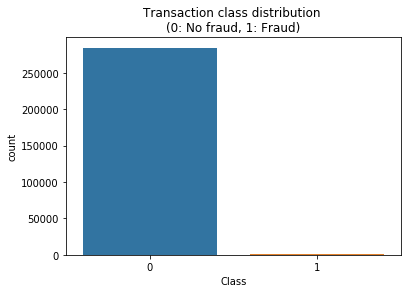

In [5]:
plt.title('Transaction class distribution \n(0: No fraud, 1: Fraud)')
sns.countplot(df['Class'])
plt.savefig('ClassDistributions.png')

In [4]:
# label_col, feature_cols = getFeatureList(df)

In [6]:
df_standard = standardScaler_df(df.copy())
df_robust = robustScaler_df(df.copy())
pickle.dump(df_standard, open("data/df_standard.pkl", "wb"))
pickle.dump(df_robust, open("data/df_robust.pkl", "wb"))

In [7]:
df_fraud_standard = df_standard[df_standard['Class'] == 1].copy()
pickle.dump(df_fraud_standard, open("data/df_fraud_all_standard.pkl", "wb"))
df_fraud_robust = df_robust[df_robust['Class'] == 1].copy()
pickle.dump(df_fraud_robust, open("data/df_fraud_all_robust.pkl", "wb"))

In [8]:
dropTime(df_standard)
dropTime(df_robust)
pickle.dump(df_standard, open("data/df_standard_noTime.pkl", "wb"))
pickle.dump(df_robust, open("data/df_robust_noTime.pkl", "wb"))

In [9]:
df_fraud_standard = df_standard[df_standard['Class'] == 1].copy()
df_fraud_robust = df_robust[df_robust['Class'] == 1].copy()

In [10]:
pickle.dump(df_fraud_standard, open("data/df_fraud_all_standard_noTime.pkl", "wb"))
pickle.dump(df_fraud_robust, open("data/df_fraud_all_robust_noTime.pkl", "wb"))

In [11]:
file_name = 'data/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
df_fraud = df[df['Class'] == 1].copy()
df_fraud.drop('Class', axis = 1, inplace = True)
df_fraud.shape

(492, 30)

In [13]:
df_fraud_standard = standardScaler_df(df_fraud.copy())
df_fraud_robust = robustScaler_df(df_fraud.copy())
pickle.dump(df_fraud_standard, open("data/df_fraud_standard.pkl", "wb"))
pickle.dump(df_fraud_robust, open("data/df_fraud_robust.pkl", "wb"))

In [14]:
dropTime(df_fraud_standard)
dropTime(df_fraud_robust)
pickle.dump(df_fraud_standard, open("data/df_fraud_standard_noTime.pkl", "wb"))
pickle.dump(df_fraud_robust, open("data/df_fraud_robust_noTime.pkl", "wb"))

# Split dataset

In [34]:
file_name = 'data/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
df = pickle.load(open("data/df_standard.pkl", "rb"))

In [17]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [18]:
X = df.drop('Class', axis=1)
y = df['Class']

In [19]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f'Train size: {train_X.shape}, Test size: {test_X.shape}')

Train size: (227845, 30), Test size: (56962, 30)


In [20]:
train_X['Time'] = RobustScaler().fit_transform(train_X['Time'].values.reshape(-1, 1))
train_X['Amount'] = RobustScaler().fit_transform(train_X['Amount'].values.reshape(-1, 1))
test_X['Time'] = RobustScaler().fit_transform(test_X['Time'].values.reshape(-1, 1))
test_X['Amount'] = RobustScaler().fit_transform(test_X['Amount'].values.reshape(-1, 1))

C:\Users\chinne\Anaconda3\envs\DGM\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\chinne\Anaconda3\envs\DGM\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\chinne\Anaconda3\envs\DGM\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [21]:
train_unique_label, train_counts_label = np.unique(train_y, return_counts=True)
test_unique_label, test_counts_label = np.unique(test_y, return_counts=True)

In [22]:
train_X.drop('Time', axis=1, inplace=True)

C:\Users\chinne\Anaconda3\envs\DGM\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
test_X.drop('Time', axis=1, inplace=True)

In [24]:
print('Label Distributions: \n')
print(train_counts_label/ len(train_y))
print(test_counts_label/ len(test_y))

Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]


# XGBoost

In [26]:
import xgboost as xgb
start_time = time.time()
dtrain = xgb.DMatrix(train_X.values, train_y.values)
dtest = xgb.DMatrix(test_X.values)
# specify parameters via map
param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }
model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = model.predict(dtest)
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

Time elapsed to train:  23.55313754081726


In [27]:
preds = preds.round()

In [30]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.903052
Recall Score: 0.806122
Precision Score: 0.987500
F1 Score: 0.887640
Accuracy Score: 0.999649
---------------------------------------------------------------------------------------------------------------------------------------


In [30]:
# start_time = time.time()
# dtrain = xgb.DMatrix(train_X, label=train_y.values)
# dtest = xgb.DMatrix(test_X, label=test_y.values)


# model = xgb.train(param, 
#                 dtrain, 
#                 num_boost_round=100,
#                 early_stopping_rounds=20,
#                 evals=[(dtrain, 'train'), (dtest, 'test')])
# # Measure End Time
# elapsed_time = time.time() - start_time
# print('Time elapsed to train: ', elapsed_time)

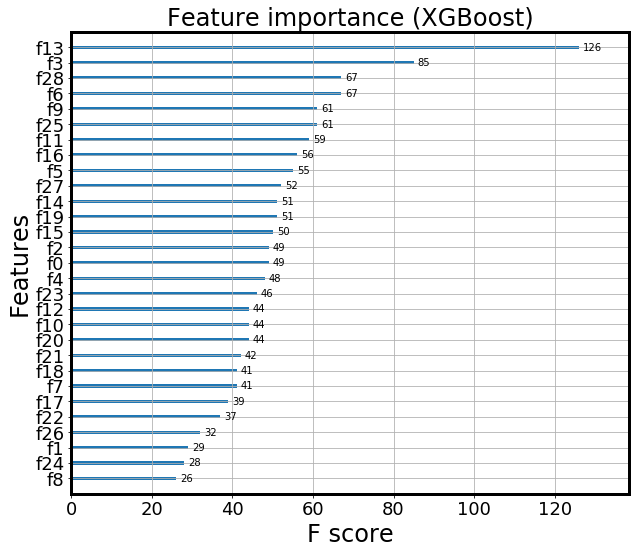

In [31]:
mpl.rcParams['axes.linewidth'] = 3 #set the value globally

# plot feature importance
fig, ax = plt.subplots(figsize=(10, 8.5))
xgb.plot_importance(model,ax=ax)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.xlabel('F score', fontsize = 24) #32
plt.ylabel('Features', fontsize = 24)#32
plt.title('Feature importance (XGBoost)', fontsize = 24) #32

plt.show()

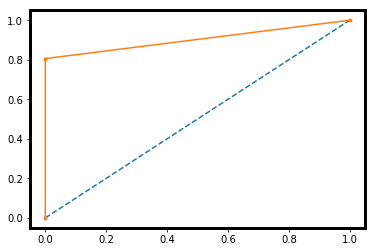

In [32]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(test_y, preds)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

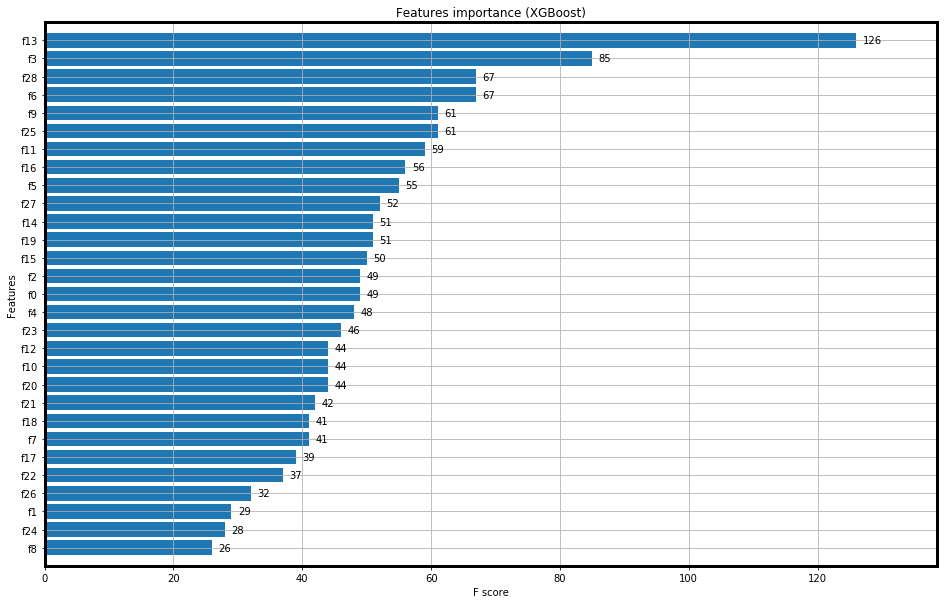

In [33]:
fig, (ax) = plt.subplots(ncols=1, figsize=(16,10))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax) 
plt.show()

## Precision-Recall curves should be used when there is a moderate to large class imbalance.

In [35]:
from sklearn.metrics import precision_recall_curve

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
# SMOTE
smt = SMOTE(ratio={1:5379}, random_state=42, n_jobs=-1)

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_smt), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_smt))

<a id="VanillaGAN setup"><h1>VanillaGAN setup and training</h1></a>

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
print(pd.__version__)

In [57]:
df_fraud_all_robust_noTime = pickle.load(open("data/df_fraud_all_robust_noTime.pkl", "rb"))
df_fraud_all_robust = pickle.load(open("data/df_fraud_all_robust.pkl", "rb"))
df_fraud_all_standard_noTime = pickle.load(open("data/df_fraud_all_standard_noTime.pkl", "rb"))
df_fraud_all_standard = pickle.load(open("data/df_fraud_all_standard.pkl", "rb"))
df_fraud_robust = pickle.load(open("data/df_fraud_robust.pkl", "rb"))
df_fraud_robust_noTime = pickle.load(open("data/df_fraud_robust_noTime.pkl", "rb"))
df_fraud_standard = pickle.load(open("data/df_fraud_standard.pkl", "rb"))
df_fraud_standard_noTime = pickle.load(open("data/df_fraud_standard_noTime.pkl", "rb"))
df_fraud_robust = pickle.load(open("data/df_fraud_robust.pkl", "rb"))
df_fraud_robust_noTime = pickle.load(open("data/df_fraud_robust_noTime.pkl", "rb"))
df_fraud_standard = pickle.load(open("data/df_fraud_standard.pkl", "rb"))
df_fraud_standard_noTime = pickle.load(open("data/df_fraud_standard_noTime.pkl", "rb"))

In [58]:
df_fraud_all_robust_noTime.name = 'df_fraud_all_robust_noTime'
df_fraud_all_robust.name = 'df_fraud_all_robust'
df_fraud_all_standard_noTime.name = 'df_fraud_all_standard_noTime'
df_fraud_all_standard.name = 'df_fraud_all_standard'
df_fraud_robust.name = 'df_fraud_robust'
df_fraud_robust_noTime.name = 'df_fraud_robust_noTime'
df_fraud_standard.name = 'df_fraud_standard'
df_fraud_standard_noTime.name = 'df_fraud_standard_noTime'
df_fraud_robust.name = 'df_fraud_robust'
df_fraud_robust_noTime.name = 'df_fraud_robust_noTime'
df_fraud_standard.name = 'df_fraud_standard'
df_fraud_standard_noTime.name = 'df_fraud_standard_noTime'

In [50]:
df_fraud_robust.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
541,-0.861545,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.088188
623,-0.860789,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,4.955191
4920,-0.815054,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,2.199256
6108,-0.786122,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,0.474306
6329,-0.780013,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.078654


In [59]:
list_df = [
    df_fraud_all_robust_noTime,
    df_fraud_all_robust,
    df_fraud_all_standard_noTime,
    df_fraud_all_standard,
    df_fraud_robust,
    df_fraud_robust_noTime,
    df_fraud_standard,
    df_fraud_standard_noTime,
    df_fraud_robust,
    df_fraud_robust_noTime,
    df_fraud_standard,
    df_fraud_standard_noTime]

In [60]:
for df in list_df:
    for col in df.columns: 
        if 'Class' in col:
            df.drop('Class', axis = 1, inplace = True)

In [61]:
df_fraud_all_robust.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
541,-0.990214,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.307413
623,-0.989438,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,7.084469
4920,-0.942563,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,3.045204
6108,-0.912910,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,0.517013
6329,-0.906648,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.293440


29
torch.Size([492, 29])
Starting Training Loop...
epoch: 0, Accuracy: 0.983739837398374
[Epoch 0/1500] [Batch 7/8] [D loss: 0.675065] [G loss: 1.676766]
epoch: 10, Accuracy: 0.991869918699187
[Epoch 10/1500] [Batch 7/8] [D loss: 0.271905] [G loss: 1.399224]
epoch: 20, Accuracy: 0.9898373983739838
[Epoch 20/1500] [Batch 7/8] [D loss: 0.369032] [G loss: 1.337988]
epoch: 30, Accuracy: 0.9796747967479674
[Epoch 30/1500] [Batch 7/8] [D loss: 0.424494] [G loss: 1.289642]
epoch: 40, Accuracy: 0.9796747967479674
[Epoch 40/1500] [Batch 7/8] [D loss: 0.407668] [G loss: 1.270134]
epoch: 50, Accuracy: 0.9735772357723578
[Epoch 50/1500] [Batch 7/8] [D loss: 0.318070] [G loss: 1.256258]
epoch: 60, Accuracy: 0.9735772357723578
[Epoch 60/1500] [Batch 7/8] [D loss: 0.360623] [G loss: 1.251865]
epoch: 70, Accuracy: 0.9857723577235772
[Epoch 70/1500] [Batch 7/8] [D loss: 0.252281] [G loss: 1.235312]
epoch: 80, Accuracy: 0.9735772357723578
[Epoch 80/1500] [Batch 7/8] [D loss: 0.333744] [G loss: 1.227890]

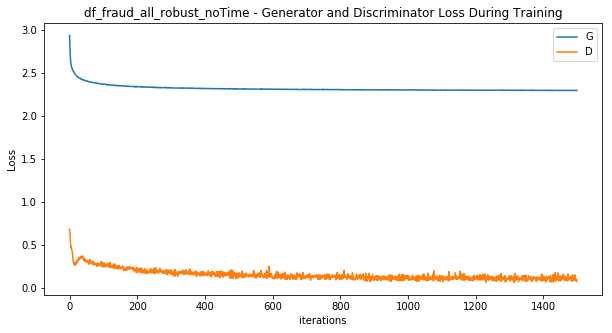

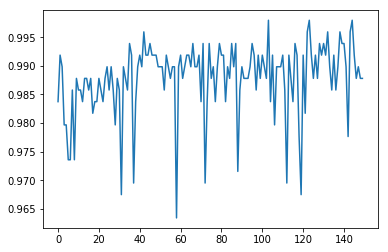

30
torch.Size([492, 30])
Starting Training Loop...
epoch: 0, Accuracy: 0.9776422764227642
[Epoch 0/1500] [Batch 7/8] [D loss: 0.655920] [G loss: 1.658958]
epoch: 10, Accuracy: 0.9776422764227642
[Epoch 10/1500] [Batch 7/8] [D loss: 0.240934] [G loss: 1.378631]
epoch: 20, Accuracy: 0.9857723577235772
[Epoch 20/1500] [Batch 7/8] [D loss: 0.219438] [G loss: 1.327378]
epoch: 30, Accuracy: 0.9857723577235772
[Epoch 30/1500] [Batch 7/8] [D loss: 0.548917] [G loss: 1.284198]
epoch: 40, Accuracy: 0.9857723577235772
[Epoch 40/1500] [Batch 7/8] [D loss: 0.502086] [G loss: 1.261436]
epoch: 50, Accuracy: 0.9715447154471545
[Epoch 50/1500] [Batch 7/8] [D loss: 0.467155] [G loss: 1.252808]
epoch: 60, Accuracy: 0.967479674796748
[Epoch 60/1500] [Batch 7/8] [D loss: 0.384245] [G loss: 1.231876]
epoch: 70, Accuracy: 0.9796747967479674
[Epoch 70/1500] [Batch 7/8] [D loss: 0.366254] [G loss: 1.223561]
epoch: 80, Accuracy: 0.9634146341463414
[Epoch 80/1500] [Batch 7/8] [D loss: 0.333418] [G loss: 1.221660

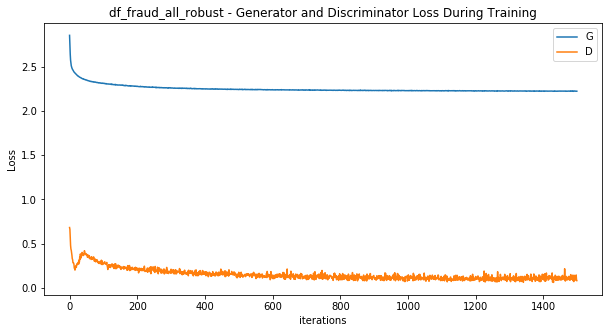

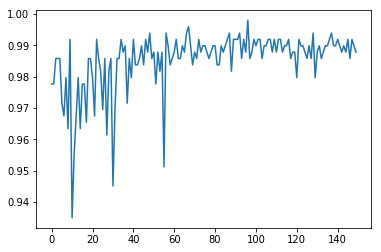

29
torch.Size([492, 29])
Starting Training Loop...
epoch: 0, Accuracy: 0.959349593495935
[Epoch 0/1500] [Batch 7/8] [D loss: 0.689896] [G loss: 1.612267]
epoch: 10, Accuracy: 0.991869918699187
[Epoch 10/1500] [Batch 7/8] [D loss: 0.354570] [G loss: 1.356325]
epoch: 20, Accuracy: 0.983739837398374
[Epoch 20/1500] [Batch 7/8] [D loss: 0.282481] [G loss: 1.299449]
epoch: 30, Accuracy: 0.9878048780487805
[Epoch 30/1500] [Batch 7/8] [D loss: 0.372308] [G loss: 1.267293]
epoch: 40, Accuracy: 0.9857723577235772
[Epoch 40/1500] [Batch 7/8] [D loss: 0.442650] [G loss: 1.237494]
epoch: 50, Accuracy: 0.9796747967479674
[Epoch 50/1500] [Batch 7/8] [D loss: 0.379403] [G loss: 1.222492]
epoch: 60, Accuracy: 0.9878048780487805
[Epoch 60/1500] [Batch 7/8] [D loss: 0.332508] [G loss: 1.205305]
epoch: 70, Accuracy: 0.9857723577235772
[Epoch 70/1500] [Batch 7/8] [D loss: 0.330755] [G loss: 1.201763]
epoch: 80, Accuracy: 0.983739837398374
[Epoch 80/1500] [Batch 7/8] [D loss: 0.293481] [G loss: 1.192072]
e

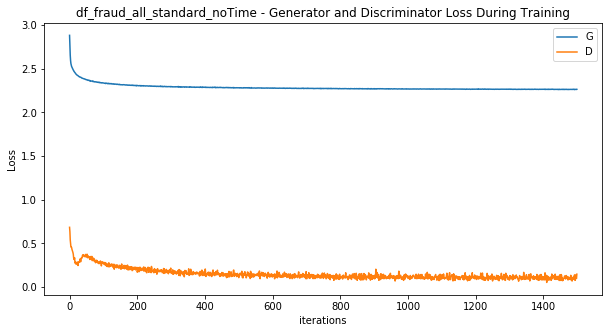

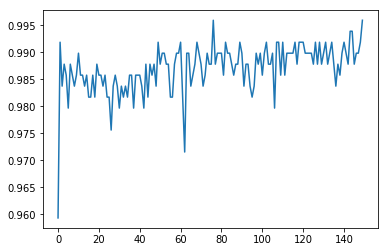

30
torch.Size([492, 30])
Starting Training Loop...
epoch: 0, Accuracy: 0.483739837398374
[Epoch 0/1500] [Batch 7/8] [D loss: 0.685876] [G loss: 1.617710]
epoch: 10, Accuracy: 0.4898373983739837
[Epoch 10/1500] [Batch 7/8] [D loss: 0.280139] [G loss: 1.369699]
epoch: 20, Accuracy: 0.9776422764227642
[Epoch 20/1500] [Batch 7/8] [D loss: 0.225823] [G loss: 1.320704]
epoch: 30, Accuracy: 0.9451219512195121
[Epoch 30/1500] [Batch 7/8] [D loss: 0.259865] [G loss: 1.279006]
epoch: 40, Accuracy: 0.9471544715447154
[Epoch 40/1500] [Batch 7/8] [D loss: 0.435838] [G loss: 1.250653]
epoch: 50, Accuracy: 0.975609756097561
[Epoch 50/1500] [Batch 7/8] [D loss: 0.481737] [G loss: 1.228597]
epoch: 60, Accuracy: 0.9715447154471545
[Epoch 60/1500] [Batch 7/8] [D loss: 0.362173] [G loss: 1.221847]
epoch: 70, Accuracy: 0.9857723577235772
[Epoch 70/1500] [Batch 7/8] [D loss: 0.314562] [G loss: 1.214909]
epoch: 80, Accuracy: 0.9817073170731707
[Epoch 80/1500] [Batch 7/8] [D loss: 0.299918] [G loss: 1.199765]

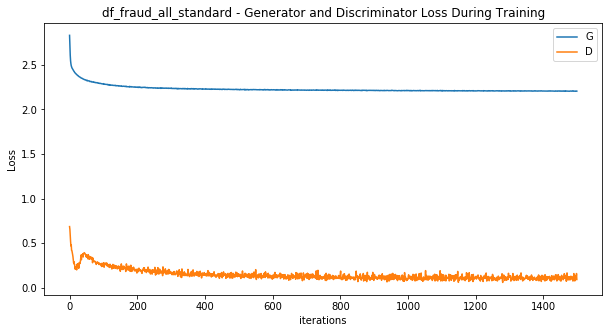

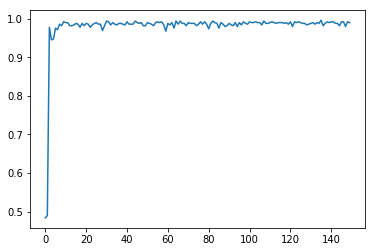

30
torch.Size([492, 30])
Starting Training Loop...
epoch: 0, Accuracy: 0.9715447154471545
[Epoch 0/1500] [Batch 7/8] [D loss: 0.674718] [G loss: 1.632869]
epoch: 10, Accuracy: 0.9126016260162602
[Epoch 10/1500] [Batch 7/8] [D loss: 0.288519] [G loss: 1.371954]
epoch: 20, Accuracy: 0.9613821138211383
[Epoch 20/1500] [Batch 7/8] [D loss: 0.284755] [G loss: 1.308559]
epoch: 30, Accuracy: 0.9369918699186992
[Epoch 30/1500] [Batch 7/8] [D loss: 0.352706] [G loss: 1.269778]
epoch: 40, Accuracy: 0.9288617886178862
[Epoch 40/1500] [Batch 7/8] [D loss: 0.302213] [G loss: 1.233456]
epoch: 50, Accuracy: 0.9308943089430894
[Epoch 50/1500] [Batch 7/8] [D loss: 0.380284] [G loss: 1.225163]
epoch: 60, Accuracy: 0.926829268292683
[Epoch 60/1500] [Batch 7/8] [D loss: 0.377548] [G loss: 1.205824]
epoch: 70, Accuracy: 0.926829268292683
[Epoch 70/1500] [Batch 7/8] [D loss: 0.360343] [G loss: 1.196442]
epoch: 80, Accuracy: 0.9532520325203252
[Epoch 80/1500] [Batch 7/8] [D loss: 0.448561] [G loss: 1.196231]

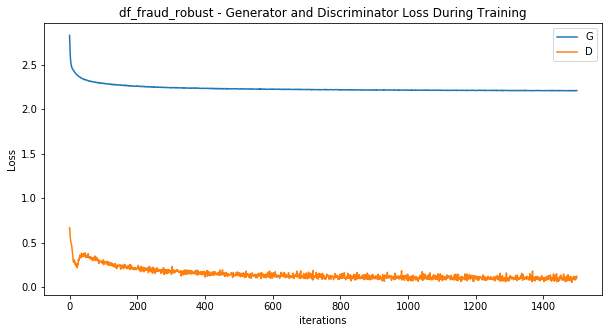

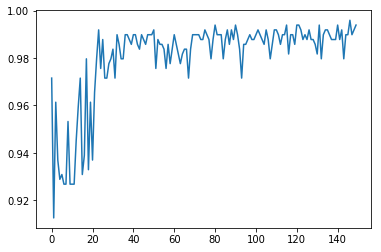

29
torch.Size([492, 29])
Starting Training Loop...
epoch: 0, Accuracy: 0.9715447154471545
[Epoch 0/1500] [Batch 7/8] [D loss: 0.687901] [G loss: 1.663781]
epoch: 10, Accuracy: 0.9796747967479674
[Epoch 10/1500] [Batch 7/8] [D loss: 0.269553] [G loss: 1.381925]
epoch: 20, Accuracy: 0.9796747967479674
[Epoch 20/1500] [Batch 7/8] [D loss: 0.232656] [G loss: 1.331746]
epoch: 30, Accuracy: 0.9878048780487805
[Epoch 30/1500] [Batch 7/8] [D loss: 0.261864] [G loss: 1.281791]
epoch: 40, Accuracy: 0.9715447154471545
[Epoch 40/1500] [Batch 7/8] [D loss: 0.301688] [G loss: 1.263775]
epoch: 50, Accuracy: 0.9796747967479674
[Epoch 50/1500] [Batch 7/8] [D loss: 0.330812] [G loss: 1.240329]
epoch: 60, Accuracy: 0.9796747967479674
[Epoch 60/1500] [Batch 7/8] [D loss: 0.312889] [G loss: 1.228867]
epoch: 70, Accuracy: 0.9695121951219512
[Epoch 70/1500] [Batch 7/8] [D loss: 0.324531] [G loss: 1.221088]
epoch: 80, Accuracy: 0.9796747967479674
[Epoch 80/1500] [Batch 7/8] [D loss: 0.371877] [G loss: 1.21268

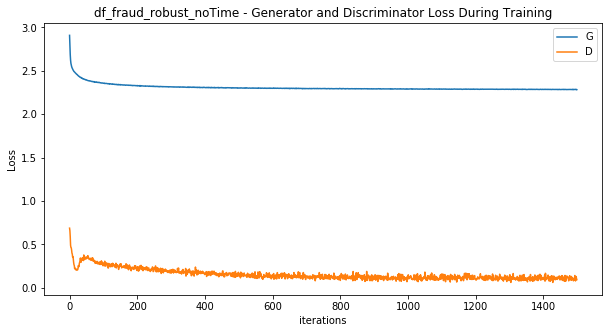

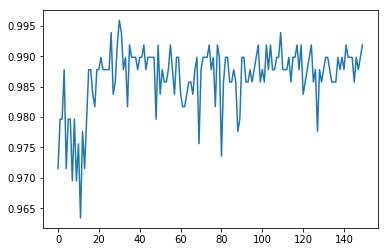

30
torch.Size([492, 30])
Starting Training Loop...
epoch: 0, Accuracy: 0.983739837398374
[Epoch 0/1500] [Batch 7/8] [D loss: 0.657060] [G loss: 1.635675]
epoch: 10, Accuracy: 0.9796747967479674
[Epoch 10/1500] [Batch 7/8] [D loss: 0.419916] [G loss: 1.361764]
epoch: 20, Accuracy: 0.9715447154471545
[Epoch 20/1500] [Batch 7/8] [D loss: 0.297631] [G loss: 1.310673]
epoch: 30, Accuracy: 0.967479674796748
[Epoch 30/1500] [Batch 7/8] [D loss: 0.321935] [G loss: 1.276004]
epoch: 40, Accuracy: 0.9552845528455285
[Epoch 40/1500] [Batch 7/8] [D loss: 0.359201] [G loss: 1.247721]
epoch: 50, Accuracy: 0.9817073170731707
[Epoch 50/1500] [Batch 7/8] [D loss: 0.436983] [G loss: 1.226858]
epoch: 60, Accuracy: 0.9715447154471545
[Epoch 60/1500] [Batch 7/8] [D loss: 0.350588] [G loss: 1.215099]
epoch: 70, Accuracy: 0.9573170731707317
[Epoch 70/1500] [Batch 7/8] [D loss: 0.256133] [G loss: 1.210577]
epoch: 80, Accuracy: 0.9735772357723578
[Epoch 80/1500] [Batch 7/8] [D loss: 0.237429] [G loss: 1.204139]

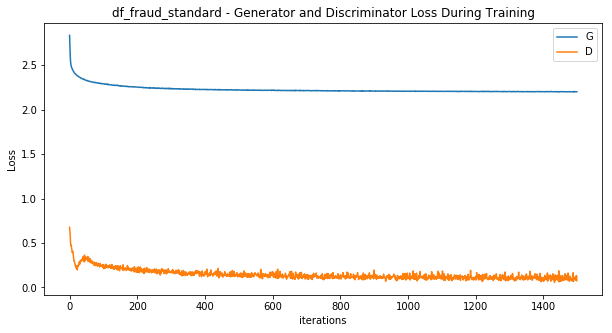

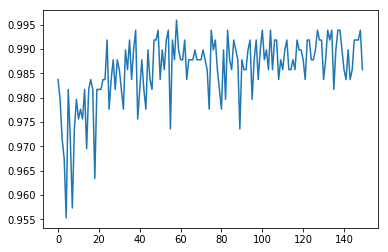

29
torch.Size([492, 29])
Starting Training Loop...
epoch: 0, Accuracy: 0.9898373983739838
[Epoch 0/1500] [Batch 7/8] [D loss: 0.672616] [G loss: 1.659575]
epoch: 10, Accuracy: 0.9857723577235772
[Epoch 10/1500] [Batch 7/8] [D loss: 0.308476] [G loss: 1.354484]
epoch: 20, Accuracy: 0.9776422764227642
[Epoch 20/1500] [Batch 7/8] [D loss: 0.284614] [G loss: 1.293329]
epoch: 30, Accuracy: 0.9715447154471545
[Epoch 30/1500] [Batch 7/8] [D loss: 0.348008] [G loss: 1.261819]
epoch: 40, Accuracy: 0.9735772357723578
[Epoch 40/1500] [Batch 7/8] [D loss: 0.402624] [G loss: 1.233304]
epoch: 50, Accuracy: 0.991869918699187
[Epoch 50/1500] [Batch 7/8] [D loss: 0.382262] [G loss: 1.217266]
epoch: 60, Accuracy: 0.983739837398374
[Epoch 60/1500] [Batch 7/8] [D loss: 0.419641] [G loss: 1.205807]
epoch: 70, Accuracy: 0.9715447154471545
[Epoch 70/1500] [Batch 7/8] [D loss: 0.322203] [G loss: 1.198039]
epoch: 80, Accuracy: 0.975609756097561
[Epoch 80/1500] [Batch 7/8] [D loss: 0.262102] [G loss: 1.191263]


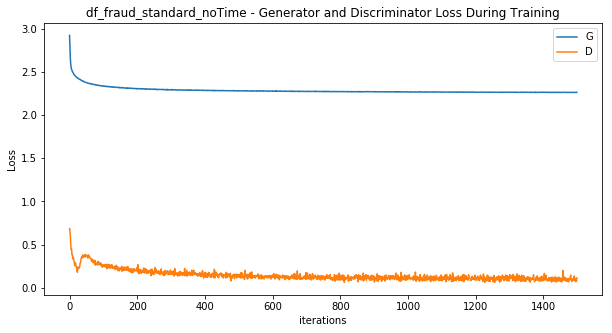

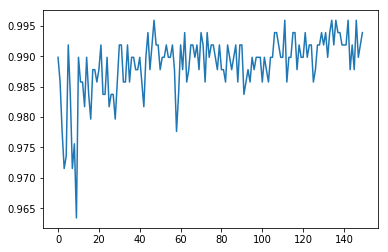

30
torch.Size([492, 30])
Starting Training Loop...
epoch: 0, Accuracy: 0.9796747967479674
[Epoch 0/1500] [Batch 7/8] [D loss: 0.686553] [G loss: 1.662745]
epoch: 10, Accuracy: 0.9776422764227642
[Epoch 10/1500] [Batch 7/8] [D loss: 0.317282] [G loss: 1.363173]
epoch: 20, Accuracy: 0.983739837398374
[Epoch 20/1500] [Batch 7/8] [D loss: 0.222347] [G loss: 1.312393]
epoch: 30, Accuracy: 0.9796747967479674
[Epoch 30/1500] [Batch 7/8] [D loss: 0.423540] [G loss: 1.279470]
epoch: 40, Accuracy: 0.9410569105691057
[Epoch 40/1500] [Batch 7/8] [D loss: 0.361019] [G loss: 1.255058]
epoch: 50, Accuracy: 0.9349593495934959
[Epoch 50/1500] [Batch 7/8] [D loss: 0.497079] [G loss: 1.232513]
epoch: 60, Accuracy: 0.9654471544715447
[Epoch 60/1500] [Batch 7/8] [D loss: 0.435996] [G loss: 1.216944]
epoch: 70, Accuracy: 0.9410569105691057
[Epoch 70/1500] [Batch 7/8] [D loss: 0.431166] [G loss: 1.209044]
epoch: 80, Accuracy: 0.9634146341463414
[Epoch 80/1500] [Batch 7/8] [D loss: 0.287460] [G loss: 1.201880

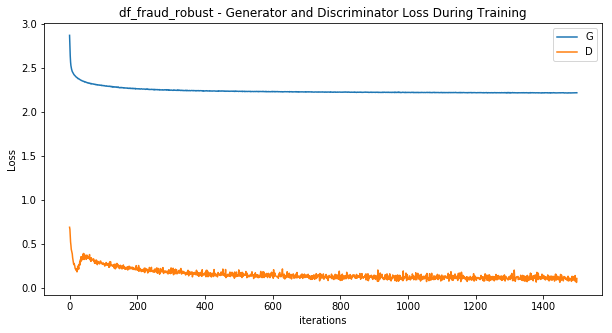

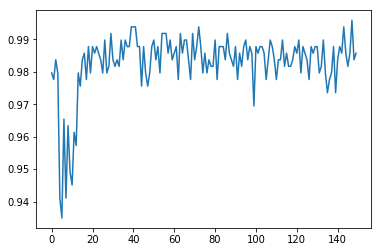

29
torch.Size([492, 29])
Starting Training Loop...
epoch: 0, Accuracy: 0.9878048780487805
[Epoch 0/1500] [Batch 7/8] [D loss: 0.650671] [G loss: 1.663435]
epoch: 10, Accuracy: 0.975609756097561
[Epoch 10/1500] [Batch 7/8] [D loss: 0.324778] [G loss: 1.363420]
epoch: 20, Accuracy: 0.9776422764227642
[Epoch 20/1500] [Batch 7/8] [D loss: 0.303693] [G loss: 1.310689]
epoch: 30, Accuracy: 0.9878048780487805
[Epoch 30/1500] [Batch 7/8] [D loss: 0.470953] [G loss: 1.271610]
epoch: 40, Accuracy: 0.991869918699187
[Epoch 40/1500] [Batch 7/8] [D loss: 0.518636] [G loss: 1.248057]
epoch: 50, Accuracy: 0.9898373983739838
[Epoch 50/1500] [Batch 7/8] [D loss: 0.427300] [G loss: 1.234291]
epoch: 60, Accuracy: 0.9878048780487805
[Epoch 60/1500] [Batch 7/8] [D loss: 0.422276] [G loss: 1.219194]
epoch: 70, Accuracy: 0.9857723577235772
[Epoch 70/1500] [Batch 7/8] [D loss: 0.356245] [G loss: 1.212104]
epoch: 80, Accuracy: 0.9878048780487805
[Epoch 80/1500] [Batch 7/8] [D loss: 0.365554] [G loss: 1.208072]

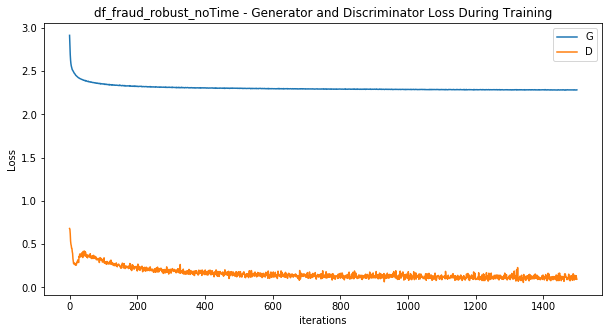

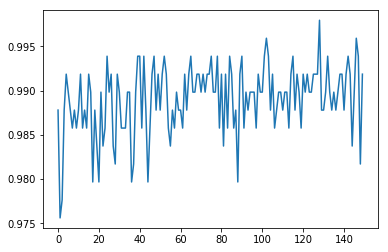

30
torch.Size([492, 30])
Starting Training Loop...
epoch: 0, Accuracy: 0.9715447154471545
[Epoch 0/1500] [Batch 7/8] [D loss: 0.691405] [G loss: 1.670941]
epoch: 10, Accuracy: 0.9817073170731707
[Epoch 10/1500] [Batch 7/8] [D loss: 0.323835] [G loss: 1.364301]
epoch: 20, Accuracy: 0.9796747967479674
[Epoch 20/1500] [Batch 7/8] [D loss: 0.296665] [G loss: 1.313992]
epoch: 30, Accuracy: 0.9695121951219512
[Epoch 30/1500] [Batch 7/8] [D loss: 0.444045] [G loss: 1.273778]
epoch: 40, Accuracy: 0.9329268292682927
[Epoch 40/1500] [Batch 7/8] [D loss: 0.455622] [G loss: 1.250242]
epoch: 50, Accuracy: 0.9613821138211383
[Epoch 50/1500] [Batch 7/8] [D loss: 0.510820] [G loss: 1.238128]
epoch: 60, Accuracy: 0.9695121951219512
[Epoch 60/1500] [Batch 7/8] [D loss: 0.309694] [G loss: 1.219907]
epoch: 70, Accuracy: 0.9654471544715447
[Epoch 70/1500] [Batch 7/8] [D loss: 0.410637] [G loss: 1.212424]
epoch: 80, Accuracy: 0.959349593495935
[Epoch 80/1500] [Batch 7/8] [D loss: 0.297108] [G loss: 1.204072

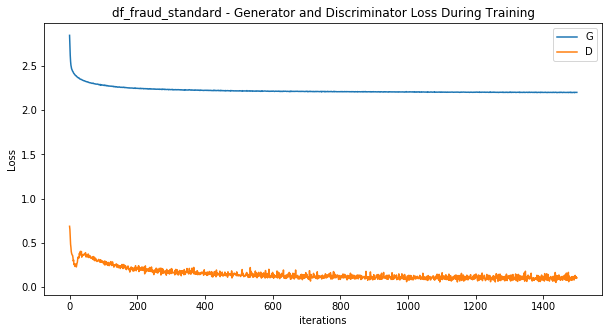

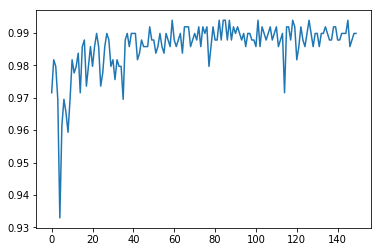

29
torch.Size([492, 29])
Starting Training Loop...
epoch: 0, Accuracy: 0.9735772357723578
[Epoch 0/1500] [Batch 7/8] [D loss: 0.659179] [G loss: 1.637596]
epoch: 10, Accuracy: 0.9878048780487805
[Epoch 10/1500] [Batch 7/8] [D loss: 0.346276] [G loss: 1.350784]
epoch: 20, Accuracy: 0.983739837398374
[Epoch 20/1500] [Batch 7/8] [D loss: 0.311488] [G loss: 1.302303]
epoch: 30, Accuracy: 0.9695121951219512
[Epoch 30/1500] [Batch 7/8] [D loss: 0.282803] [G loss: 1.258055]
epoch: 40, Accuracy: 0.9695121951219512
[Epoch 40/1500] [Batch 7/8] [D loss: 0.417571] [G loss: 1.242855]
epoch: 50, Accuracy: 0.9817073170731707
[Epoch 50/1500] [Batch 7/8] [D loss: 0.447540] [G loss: 1.225999]
epoch: 60, Accuracy: 0.9715447154471545
[Epoch 60/1500] [Batch 7/8] [D loss: 0.368267] [G loss: 1.208138]
epoch: 70, Accuracy: 0.9857723577235772
[Epoch 70/1500] [Batch 7/8] [D loss: 0.316877] [G loss: 1.192520]
epoch: 80, Accuracy: 0.9654471544715447
[Epoch 80/1500] [Batch 7/8] [D loss: 0.422966] [G loss: 1.190157

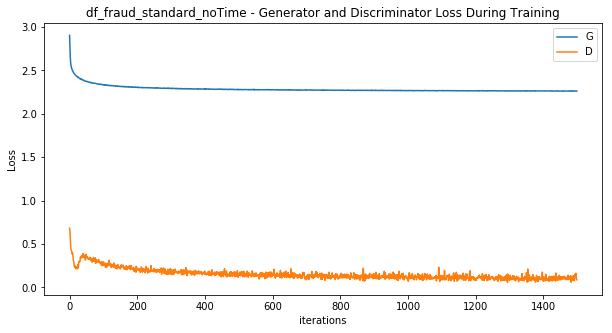

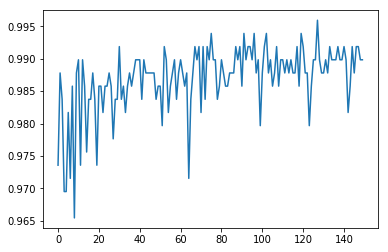

In [56]:
for i, df in enumerate(list_df):
#     df.drop('Class', axis=1, inplace=True)
    print(df.shape[1])
    dataloader = prepareDataset(df, batch_size = 64, device = 'cpu', label = 'no')
    print(dataloader.dataset.features.size())
    xgblosses, G_losses, D_losses =aae.train(dataloader, prefix=df.name, data_dim=df.shape[1], h_dim=100, z_dim=10, lr=0.002, num_epochs=1500)
    plt.figure(figsize=(10,5))
    plt.title(f"{df.name} - Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    # plt.savefig('df_train_noTime_robust.png')
    # plt.savefig('df_train_Time_robust.png')
    # plt.savefig('df_train_noTime_standard.png')
    plt.savefig(f'AAELosses_{df.name}.png')
    plt.show()
    w = 10
    a = pd.DataFrame(xgblosses[:])#.rolling(w).mean()
    plt.plot(a)
    plt.savefig(f'xgblosses_{i}_AAE_{df.name}.png')
    plt.show()

In [ ]:
for i, df in enumerate(list_df):
#     df.drop('Class', axis=1, inplace=True)
    print(df.shape[1])
    dataloader = prepareDataset(df, batch_size = 64, device = 'cpu', label = 'no')
    print(dataloader.dataset.features.size())
    xgblosses, G_losses, D_losses =aae.train(dataloader, prefix=df.name, data_dim=df.shape[1], h_dim=100, z_dim=10, lr=0.002, num_epochs=1500)
    plt.figure(figsize=(10,5))
    plt.title(f"{df.name} - Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    # plt.savefig('df_train_noTime_robust.png')
    # plt.savefig('df_train_Time_robust.png')
    # plt.savefig('df_train_noTime_standard.png')
    plt.savefig(f'AAELosses_{df.name}.png')
    plt.show()
    w = 10
    a = pd.DataFrame(xgblosses[:])#.rolling(w).mean()
    plt.plot(a)
    plt.savefig(f'xgblosses_{i}_AAE_{df.name}.png')
    plt.show()

In [2]:
for i, df in enumerate(list_df):
    print(df.shape[1])
    df2 = prepareDataset(df, batch_size = 64, device = 'cpu', label = 'no')
    print(df2.dataset.features.size())
    xgblosses, G_losses, D_losses = gan.train(df2, prefix=df.name, randomNoise_dim = 30, hidden_dim = 64, realData_dim =df.shape[1], lr = 0.002, num_epochs=1500, device='cpu')
    print(min(xgblosses))
    plt.figure(figsize=(10,5))
    plt.title(f"{df.name}Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    # plt.savefig('df_train_noTime_robust.png')
    # plt.savefig('df_train_Time_robust.png')
    # plt.savefig('df_train_noTime_standard.png')
    plt.savefig(f'GAN_{df.name}.png')
    plt.show()
    w = 10
    a = pd.DataFrame(xgblosses[:]).rolling(w).mean()
    plt.plot(a)
    plt.savefig(f'xgblosses_{i}_GAN_{df.name}.png')
    plt.show()

NameError: name 'list_df' is not defined

# Testing - Generated Data

In [167]:
data = pd.read_csv("data/creditcard.csv")

In [168]:
data_dim = 30
label_dim = 0
train_fraction = 0.8
X_col = data.columns[:-1]
y_col = data.columns[-1]

folds = 5

In [169]:
for df in list_df:
    print(df.name)

df_fraud_all_robust_noTime
df_fraud_all_robust
df_fraud_all_standard_noTime
df_fraud_all_standard
df_fraud_robust
df_fraud_robust_noTime
df_fraud_standard
df_fraud_standard_noTime
df_fraud_robust
df_fraud_robust_noTime
df_fraud_standard
df_fraud_standard_noTime


In [170]:
prefix = 'df_fraud_all_robust_noTime'
epoch = 570

In [73]:
torch.load(f'models/generator{prefix}__{str(epoch)}.pth')

{'Epochs': 570,
 'generator': OrderedDict([('main.0.weight',
               tensor([[-0.1261,  0.2385,  0.0448,  ..., -0.3061, -0.3092,  0.0605],
                       [-0.1176, -0.0622, -0.3781,  ...,  0.0405,  0.2602, -0.0972],
                       [ 0.0421,  0.0164, -0.2221,  ...,  0.0778,  0.2161, -0.1549],
                       ...,
                       [ 0.0949,  0.0547,  0.0787,  ..., -0.0961,  0.2480, -0.1125],
                       [-0.0208,  0.3194, -0.0767,  ..., -0.2271,  0.0351, -0.1043],
                       [-0.0650,  0.1271,  0.0171,  ..., -0.1237, -0.1950,  0.0428]])),
              ('main.0.bias',
               tensor([-0.5194, -0.6380, -0.4084, -0.3047,  0.0598, -0.3307, -0.2828, -0.5741,
                       -0.2764, -0.2435, -0.5392, -0.4302, -0.3460, -0.1015, -0.4151, -0.3826,
                       -0.4415, -0.1562, -0.3839, -0.4204, -0.1255, -0.7942, -0.8034, -0.4547,
                       -0.6725, -0.2628, -0.3919, -0.4038, -0.2759,  0.0092, -0.343

In [144]:
list_df = [df_train_noTime_robust, df_train_Time_robust, df_train_noTime_standard, df_train_Time_standard]

NameError: name 'df_train_noTime_robust' is not defined

In [74]:
data_new_aae = aae.generate_data(df_train_noTime_robust.name, epoch=800, data_dim = 30, h_dim = 100, z_dim =10, amount=30000, device='cpu')

TypeError: generate_data() got multiple values for argument 'epoch'

In [145]:
df_train_noTime_robust.shape[1]

NameError: name 'df_train_noTime_robust' is not defined

In [171]:
data_new_gan = vanillaGan.generate_data(df_fraud_all_robust_noTime.name, epoch=570, randomNoise_dim = 30, hidden_dim = 64, realData_dim =df_fraud_all_robust_noTime.shape[1], amount=30000, device='cpu')

In [172]:
data_new_gan = data_new_gan.detach().numpy()

In [173]:
data_new_gan.shape

(30000, 29)

In [174]:
b = np.ones((data_new_gan.shape[0],data_new_gan.shape[1]+1))
b[:,:-1] = data_new_gan

In [175]:
b.shape

(30000, 30)

In [176]:
_,feature_cols = getFeatureList(df_fraud_all_robust_noTime)
label_col = ['Class']

In [177]:
df_generatedData = pd.DataFrame(b, columns = feature_cols + label_col)

In [178]:
df_generatedData.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-4.588972,3.467119,-9.129063,7.941389,-6.696709,-2.555672,-10.981630,3.284050,-6.254227,-13.004617,...,1.863561,-1.096437,-0.073454,-0.050052,1.071167,0.000689,1.859749,1.031746,4.605475,1.0
1,-11.103539,6.053334,-13.918331,6.917860,-9.383256,-1.735602,-13.020240,4.056069,-4.138973,-13.714507,...,0.450474,0.475870,-0.841638,1.067443,-0.034778,-0.781331,-2.464262,-0.499963,0.207754,1.0
2,-0.934367,4.365862,-5.536246,6.854516,-0.283124,-2.049585,-2.749384,-0.140806,-4.565466,-6.368081,...,1.041783,-0.193407,-0.189137,-0.519743,1.272644,0.516768,1.295841,0.630096,-0.081705,1.0
3,-10.074331,5.154306,-12.341055,7.382815,-9.651581,-2.104029,-12.407073,6.922980,-5.446503,-12.222130,...,1.712174,-0.678032,-0.737670,1.100132,0.291036,-0.446520,-1.126243,-0.248145,0.768407,1.0
4,0.230991,2.086248,-3.682184,3.097362,-0.954125,-1.256011,-2.218747,0.286440,-2.585432,-5.059618,...,0.563826,-0.179425,0.034135,0.065385,0.474332,0.593931,0.566718,0.338867,1.014865,1.0


In [179]:
def split_train_test(data, test_ratio):
    test_set_size = int(len(data) * test_ratio)
    test_indices = data[:test_set_size]
    train_indices = data[test_set_size:]
    return train_indices, test_indices

In [112]:
# np.random.seed(42)
# def split_train_test(data, test_ratio):
# #     shuffled_indices = np.random.permutation(len(data))
#     test_set_size = int(len(data) * test_ratio)
#     test_indices = data[:test_set_size]
#     train_indices = data[test_set_size:]
#     return data.iloc[train_indices], data.iloc[test_indices]

In [180]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [181]:
train_set, test_set = split_train_test(data, 0.2)

In [182]:
test_set['Amount'] = RobustScaler().fit_transform(test_set['Amount'].values.reshape(-1, 1))

C:\Users\chinne\Anaconda3\envs\DGM\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [183]:
train_set.drop('Time', axis=1, inplace=True)

C:\Users\chinne\Anaconda3\envs\DGM\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
# train_set, feature_cols, label_col = prepare_df(train_set, drop_time='no', scaling='standard')

In [184]:
train_set.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
56961,1.138149,-0.698637,0.332976,0.272394,-0.629432,0.463714,-0.628447,0.096643,-1.013536,0.952361,...,-0.200924,-0.328477,-0.240835,-0.868956,0.483849,-0.256578,0.045728,0.034950,116.00,0
56962,0.017199,-0.148533,-0.095542,-0.923477,1.161514,-0.560818,0.874059,-0.141331,-0.241034,-0.073535,...,0.034412,0.099442,0.785986,-0.291115,-2.653623,0.148533,0.101011,0.124571,55.98,0
56963,1.157218,-0.400497,0.224997,-0.662346,-0.058859,0.701721,-0.468211,0.178250,0.147136,-0.162543,...,-0.082828,-0.319259,-0.084150,-1.238330,0.039034,1.321246,-0.076822,-0.002819,69.99,0
56964,1.227454,0.052971,0.074560,1.151042,-0.047766,0.092690,-0.109024,0.155374,0.385462,0.147932,...,-0.156081,-0.366528,-0.180845,-0.542113,0.751469,-0.301263,0.006493,-0.003925,5.37,0
56965,1.228671,1.260991,-1.699439,1.450723,1.079511,-1.310171,0.683609,-0.232911,-0.722463,-1.388395,...,-0.177758,-0.433050,-0.265018,-0.320238,0.880613,-0.291865,0.037405,0.083940,0.89,0


In [185]:
df_generatedData.shape

(30000, 30)

In [186]:
train_set = train_set.append(df_generatedData, ignore_index=True)

In [187]:
train_set['Amount'] = RobustScaler().fit_transform(train_set['Amount'].values.reshape(-1, 1))

In [188]:
train_set.shape

(257846, 30)

In [189]:
test_set.drop('Time', axis=1, inplace=True)

C:\Users\chinne\Anaconda3\envs\DGM\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [190]:
test_set.shape

(56961, 30)

In [ ]:
# train_set = min_max_scaler.fit_transform(train_set)
# train_set = pd.DataFrame(train_set)

In [191]:
train_set = train_set.sample(frac=1).reset_index(drop=True)

In [ ]:
# test_set = min_max_scaler.fit_transform(test_set)
# test_set = pd.DataFrame(test_set)

In [192]:
test_set = test_set.sample(frac=1).reset_index(drop=True)

In [137]:
type(train_set)

pandas.core.frame.DataFrame

In [193]:
X_train = train_set.iloc[:,:-1]
y_train = train_set.iloc[:,-1]

In [194]:
X_test = test_set.iloc[:,:-1]
y_test = test_set.iloc[:,-1]

In [195]:
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.055318,-0.406117,2.181585,-1.337705,0.216771,-1.464110,0.266623,-0.358862,2.437841,-1.846920,...,0.261307,-0.122870,0.059087,-0.199684,0.716826,0.557306,0.086593,-0.178856,-0.152722,0.144454
1,1.208255,0.087854,0.457641,0.746202,-0.718955,-1.219197,0.034443,-0.199360,0.201084,-0.011157,...,-0.138796,0.063942,0.142463,-0.041025,0.731144,0.439070,0.410214,-0.044623,0.015364,-0.053008
2,-0.777987,0.971466,1.133580,1.780993,-0.373750,0.487049,-0.169645,0.649182,-0.162295,-0.109830,...,0.038595,0.133515,0.769077,0.131043,0.137821,-0.253261,-0.075626,0.201497,0.061154,-0.056526
3,-0.970215,1.062558,0.784792,0.614614,2.533776,4.431866,-0.603575,0.346173,0.830841,-0.173168,...,-0.161472,0.674836,-0.192651,-0.258831,0.940788,0.154160,-0.040188,0.399918,0.187461,-0.136038
4,-0.818099,0.905096,1.083963,-0.953724,-0.261343,-0.707717,0.317742,0.460376,-0.373505,-1.019701,...,-0.289941,0.060130,-0.044140,0.009511,0.088239,-0.450845,0.778965,-0.100480,0.049894,-0.162919


In [200]:
X_train.shape

(257846, 29)

In [201]:
import xgboost as xgb
start_time = time.time()
dtrain = xgb.DMatrix(X_train.values, y_train.values)
dtest = xgb.DMatrix(X_test.values)
# specify parameters via map
param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }
model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = model.predict(dtest)
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

Time elapsed to train:  29.702069759368896


In [202]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.6f}'.format(recall_score(y_test.values,np.round(preds))))
print('Precision Score: {:.6f}'.format(precision_score(y_test.values, np.round(preds))))
print('F1 Score: {:.6f}'.format(f1_score(y_test.values, np.round(preds))))
print('Accuracy Score: {:.6f}'.format(accuracy_score(y_test.values,np.round(preds))))
print('roc_auc {:.6f}'.format(roc_auc_score(y_test.values, np.round(preds))))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.910828
Precision Score: 0.104151
F1 Score: 0.186928
Accuracy Score: 0.978160
roc_auc 0.944587
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, np.round(preds))
metrics.auc(fpr, tpr)

In [ ]:
import numpy as np
width = 0.8
prediction   = pred[9]
true_value = X_test[9]
indices = np.arange(len(prediction))
fig = plt.figure(figsize=(10,7))
plt.bar(indices, prediction, width=width,
       color='b', label='Predicted Value')
plt.bar([i+0.25*width for i in indices], true_value,
       width=0.5*width, color='r', alpha=0.5, label='True Value')
plt.xticks(indices+width/2.,
       ['V{}'.format(i) for i in range(len(prediction))] )
plt.legend()
plt.show()

# VAE

In [ ]:
vae2 = vae.VAE(data_dim=30, h_dim=10, z_dim=5)
# if torch.cuda.is_available():
#     vae.cuda()
# vae

## Helperfunctions

In [ ]:
def prepare_df(df, drop_time='yes', scaling='standard'):
    if (scaling == 'standard'):
        df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
        df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
    else:
        df['Time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1, 1))
        df['Amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
    if (drop_time == 'yes'):
        df.drop('Time', axis=1, inplace=True)
    label_col = [i for i in df.columns if 'Class' in i]
    feature_cols = [i for i in df.columns if i not in label_col]
    return df, label_col, feature_cols